In [114]:
%pip install composable

In [115]:
from composable import pipeable
from composable.strict import map, filter
from composable_glob import glob
from composable_utility import with_open
import composable_records as rec
import composable_tuples as tup

import re
import csv

In [116]:
from composable_utility import get, with_open, identity
from composable_object import obj, attr
from composable_origami import fold

# Project overview:
In this project, you will combine all of the text files by their type (attendance or practice quiz) in two ways: with comprehensions and using composable functions.

## Goal for part 2: 

1. Combine all **attendance and practice** files into one CSV file simultaneously.
2. Add the course and section information as columns in the resulting file.
3. Use comprehensions with records to accomplish this part.
4. You will need to make your own headers based on the README files.
5. There is no missing data, so you can use string split to split up the fixed widths.  
   - Hint for splitting.  Feel free to split the date-time column into two separate columns when splitting, just make sure you adjust the header accordingly.
   - BONUS: Do this using unfold instead of string split.
6. See Activity 2.7.2 - Combining all yearly files with comprehensions for a demonstration of a similar problem.

# Step 1: Convert txt to csv

## Reading txt files

In [117]:
(paths :=
 "./attendance_example_fixed_width/**/* Quiz*.txt"
 >> glob(recursive=True)
)

['./attendance_example_fixed_width\\dsci494s7\\Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width\\dsci494s7\\Practice Quiz - Module 1 - User Attempts.txt',
 './attendance_example_fixed_width\\dsci494s7\\Practice Quiz - Module 2 - User Attempts.txt',
 './attendance_example_fixed_width\\dsci494s7\\Practice Quiz - Module 3 - User Attempts.txt',
 './attendance_example_fixed_width\\dsci494s7\\Practice Quiz - Module 4 - User Attempts.txt',
 './attendance_example_fixed_width\\stat180s18\\Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width\\stat491s1\\Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width\\stat491s1\\Practice Quiz - Module 1 - User Attempts.txt',
 './attendance_example_fixed_width\\stat491s1\\Practice Quiz - Module 2 - User Attempts.txt',
 './attendance_example_fixed_width\\stat491s1\\Practice Quiz - Module 3 - User Attempts.txt',
 './attendance_example_fixed_width\\stat491s1\\Practice Quiz - Module 4 - User Attempt

In [118]:
(new_paths := [path.replace("\\", "/") for path in paths])

['./attendance_example_fixed_width/dsci494s7/Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width/dsci494s7/Practice Quiz - Module 1 - User Attempts.txt',
 './attendance_example_fixed_width/dsci494s7/Practice Quiz - Module 2 - User Attempts.txt',
 './attendance_example_fixed_width/dsci494s7/Practice Quiz - Module 3 - User Attempts.txt',
 './attendance_example_fixed_width/dsci494s7/Practice Quiz - Module 4 - User Attempts.txt',
 './attendance_example_fixed_width/stat180s18/Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width/stat491s1/Attendance Quiz - User Attempts.txt',
 './attendance_example_fixed_width/stat491s1/Practice Quiz - Module 1 - User Attempts.txt',
 './attendance_example_fixed_width/stat491s1/Practice Quiz - Module 2 - User Attempts.txt',
 './attendance_example_fixed_width/stat491s1/Practice Quiz - Module 3 - User Attempts.txt',
 './attendance_example_fixed_width/stat491s1/Practice Quiz - Module 4 - User Attempts.txt']

In [119]:
with open(new_paths[0], encoding ="utf-8") as f:
    lines = f.readlines()
lines[:3]

['14460432 au9747cp Jericho     Greer       1  1  1  2019-01-14 14:00:00 2019-01-14 14:06:00 100%\n',
 '14460432 au9747cp Jericho     Greer       2  1  1  2019-01-16 14:00:00 2019-01-16 14:08:00 100%\n',
 '14460432 au9747cp Jericho     Greer       3  1  1  2019-01-18 14:00:00 2019-01-18 14:05:00 100%\n']

In [120]:
split_lines = [line.split() for line in lines]
split_lines[:2]

[['14460432',
  'au9747cp',
  'Jericho',
  'Greer',
  '1',
  '1',
  '1',
  '2019-01-14',
  '14:00:00',
  '2019-01-14',
  '14:06:00',
  '100%'],
 ['14460432',
  'au9747cp',
  'Jericho',
  'Greer',
  '2',
  '1',
  '1',
  '2019-01-16',
  '14:00:00',
  '2019-01-16',
  '14:08:00',
  '100%']]

## Adding headers to the body of text

In [121]:
# List comprehension to create records (dicts) with keys. 
# Refer to the README file for more detail. 
quiz_records = [
              {'ID': line[0],       
               'UserName': line[1],
               'FirstName': line[2],  
               "LastName": line[3],
               "Attempt": line[4],
               "Score": line[5],
               "Out_Of": line[6],
               "Attempt_Start_Date": line[7],
               "Attempt_Start_Time": line[8],
               "Attempt_End_Date": line[9],
               "Attempt_End_Time": line[10],
               "Percent": line[11]
              }
    for line in split_lines]

[record for record in quiz_records][:2]

[{'ID': '14460432',
  'UserName': 'au9747cp',
  'FirstName': 'Jericho',
  'LastName': 'Greer',
  'Attempt': '1',
  'Score': '1',
  'Out_Of': '1',
  'Attempt_Start_Date': '2019-01-14',
  'Attempt_Start_Time': '14:00:00',
  'Attempt_End_Date': '2019-01-14',
  'Attempt_End_Time': '14:06:00',
  'Percent': '100%'},
 {'ID': '14460432',
  'UserName': 'au9747cp',
  'FirstName': 'Jericho',
  'LastName': 'Greer',
  'Attempt': '2',
  'Score': '1',
  'Out_Of': '1',
  'Attempt_Start_Date': '2019-01-16',
  'Attempt_Start_Time': '14:00:00',
  'Attempt_End_Date': '2019-01-16',
  'Attempt_End_Time': '14:08:00',
  'Percent': '100%'}]

## The process of saving a txt as a csv file

In [122]:
for path in new_paths:
    # Extract class section and quiz type
    class_section = path.split("/")[-2]  # (dsci494s7, stat180s18, stat491s1)
    quiz_type = path.split("/")[-1].split(" ")[0]  # (Attendance or Practice)

    # Extract module number if it exists
    module_parts = path.split("/")[-1].split(" - ")
    module_type = module_parts[1] if quiz_type == "Practice" and "Module" in module_parts[1] else "" # Attendance quiz has no Module

    # Construct output filename
    if module_type:
        output_file = f"./attendance_example_fixed_width/{class_section}/{quiz_type}_quiz_{module_type}.csv"
    else:
        output_file = f"./attendance_example_fixed_width/{class_section}/{quiz_type}_quiz.csv"

    # Extract headers
    headers = quiz_records[0].keys()

    # Write to CSV
    if quiz_records:
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(quiz_records)

        print(f"CSV file saved: {output_file}")

CSV file saved: ./attendance_example_fixed_width/dsci494s7/Attendance_quiz.csv
CSV file saved: ./attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 1.csv
CSV file saved: ./attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 2.csv
CSV file saved: ./attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 3.csv
CSV file saved: ./attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 4.csv
CSV file saved: ./attendance_example_fixed_width/stat180s18/Attendance_quiz.csv
CSV file saved: ./attendance_example_fixed_width/stat491s1/Attendance_quiz.csv
CSV file saved: ./attendance_example_fixed_width/stat491s1/Practice_quiz_Module 1.csv
CSV file saved: ./attendance_example_fixed_width/stat491s1/Practice_quiz_Module 2.csv
CSV file saved: ./attendance_example_fixed_width/stat491s1/Practice_quiz_Module 3.csv
CSV file saved: ./attendance_example_fixed_width/stat491s1/Practice_quiz_Module 4.csv


# Step 2: Handling multiple csvs

## Reading csv files

In [123]:
(paths :=
 "./attendance_example_fixed_width/*/[AP]*_quiz*.csv"
 >> glob(recursive=True)
)

['./attendance_example_fixed_width\\dsci494s7\\attendance_quiz.csv',
 './attendance_example_fixed_width\\dsci494s7\\Practice_quiz_Module 1.csv',
 './attendance_example_fixed_width\\dsci494s7\\Practice_quiz_Module 2.csv',
 './attendance_example_fixed_width\\dsci494s7\\Practice_quiz_Module 3.csv',
 './attendance_example_fixed_width\\dsci494s7\\Practice_quiz_Module 4.csv',
 './attendance_example_fixed_width\\stat180s18\\attendance_quiz.csv',
 './attendance_example_fixed_width\\stat491s1\\attendance_quiz.csv',
 './attendance_example_fixed_width\\stat491s1\\Practice_quiz_Module 1.csv',
 './attendance_example_fixed_width\\stat491s1\\Practice_quiz_Module 2.csv',
 './attendance_example_fixed_width\\stat491s1\\Practice_quiz_Module 3.csv',
 './attendance_example_fixed_width\\stat491s1\\Practice_quiz_Module 4.csv']

In [124]:
# (csv_paths := [path.replace("\\", "/") for path in paths])

(csv_paths := [path.replace("\\", "/").replace("attendance_quiz","Attendance_quiz") for path in paths])

['./attendance_example_fixed_width/dsci494s7/Attendance_quiz.csv',
 './attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 1.csv',
 './attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 2.csv',
 './attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 3.csv',
 './attendance_example_fixed_width/dsci494s7/Practice_quiz_Module 4.csv',
 './attendance_example_fixed_width/stat180s18/Attendance_quiz.csv',
 './attendance_example_fixed_width/stat491s1/Attendance_quiz.csv',
 './attendance_example_fixed_width/stat491s1/Practice_quiz_Module 1.csv',
 './attendance_example_fixed_width/stat491s1/Practice_quiz_Module 2.csv',
 './attendance_example_fixed_width/stat491s1/Practice_quiz_Module 3.csv',
 './attendance_example_fixed_width/stat491s1/Practice_quiz_Module 4.csv']

## Unfolding the file paths into records

In [125]:
get_file = lambda path: path.split('/')[-1]
get_folder = lambda path: '/'.join(path.split('/')[:-1]) + '/'
get_class = lambda path: re.search(r"([A-Za-z]{4})\d{3}", path).group()
get_section = lambda path: re.search(r"s\d{1,2}", path).group()
get_type = lambda path: path.split('/')[-1].split('_')[0]
get_module = lambda path: path.split('/')[-1].split('_')[-1].split('.')[0] if get_type(path) == 'Practice' else ''

In [126]:
(paths_and_lines :=
 [ {'file': get_file(path),
    'folder': get_folder(path),
    'class': get_class(path),
    'section': get_section(path),
    'type':   get_type(path),
    'module': get_module(path),
    'lines':  with_open(lambda f: f.readlines(), path)
   }
     for path in csv_paths
 ]
) >> map(rec.heads(2))

[{'file': 'Attendance_quiz.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Attendance',
  'module': '',
  'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   '14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n']},
 {'file': 'Practice_quiz_Module 1.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Practice',
  'module': 'Module 1',
  'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   '14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n']},
 {'file': 'Practice_quiz_Module 2.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Practi

## Extracting the headers and bodies

In [127]:
(header_and_body := 
 [record | {'header': record['lines'][0],  # This is `first` element
            'body'  : record['lines'][1:], # This is the `rest`
           }
     for record in paths_and_lines
 ]
) >> map(rec.heads(2))

[{'file': 'Attendance_quiz.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Attendance',
  'module': '',
  'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   '14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n'],
  'header': 'ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': ['14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
   '14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n']},
 {'file': 'Practice_quiz_Module 1.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Practice',
  'module': 'Module 1',
  'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,O

## Insert new columns (Class, Section, Type, Module)

In [128]:
(with_class_section_type_module_columns :=
 [record | {'header': 'Class,Section,Type,Module,' + record['header'],
            'body'  : [f"{record['class']},{record['section']},{record['type']},{record['module']}," 
                       + line for line in record['body']]
           }
     for record in header_and_body
 ]
) >> map(rec.heads(2))

[{'file': 'Attendance_quiz.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Attendance',
  'module': '',
  'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   '14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n'],
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': ['dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
   'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n']},
 {'file': 'Practice_quiz_Module 1.csv',
  'folder': './attendance_example_fixed_width/dsci494s7/',
  'class': 'dsci494',
  'section': 's7',
  'type': 'Practice',
  'module':

## Group the records by type (Attendance or Practice)

In [129]:
(all_file_types :=
 with_class_section_type_module_columns
 >> map(rec.get('type'))
 >> pipeable(set)
 >> pipeable(tuple)
)

('Attendance', 'Practice')

In [130]:
(files_by_type :=
 { type_: ...
     for type_ in all_file_types
 }
) 

{'Attendance': Ellipsis, 'Practice': Ellipsis}

In [131]:
(files_by_type :=
 { type_: [r for r in with_class_section_type_module_columns if r['type'] == type_]
     for type_ in all_file_types
 }
) >> rec.subset(all_file_types[:3]) >> rec.map(map(rec.heads(3)))

{'Attendance': [{'file': 'Attendance_quiz.csv',
   'folder': './attendance_example_fixed_width/dsci494s7/',
   'class': 'dsci494',
   'section': 's7',
   'type': 'Attendance',
   'module': '',
   'lines': ['ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
    '14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
    '14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n'],
   'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   'body': ['dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
    'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n',
    'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Gree

## Zip up the records by file type

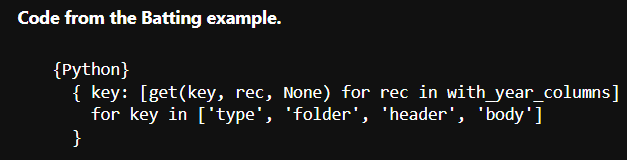

In [146]:
relevant_keys = ['folder', 'type', 'header', 'body'] 
# all_types = ['Attendance', 'Practice']

(zipped_files_by_type :=
 {type_: {key: [get(key, record, None) for record in el]
                for key in relevant_keys}
  for type_, el in files_by_type.items()
 }
) >> rec.map(rec.apply(body = map(tup.head(3)))) #>> rec.subset(all_types)[:3]

{'Attendance': {'folder': ['./attendance_example_fixed_width/dsci494s7/',
   './attendance_example_fixed_width/stat180s18/',
   './attendance_example_fixed_width/stat491s1/'],
  'type': ['Attendance', 'Attendance', 'Attendance'],
  'header': ['Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n'],
  'body': [['dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
    'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n',
    'dsci494,s7,Attenda

## Extract the first header and folder (assumes they are all the same!)

In [147]:
(zipped_files_w_header_folder :=
{type_: (record | {'header': record['header'][0],  # this is `first` header
                   'folder'  : record['folder'][0], # this is `first` folder
                   'type'  : record['type'][0], # this is `first` type
                  }
        )
 for type_, record in zipped_files_by_type.items()
} 
) >> rec.map(rec.apply(body = map(tup.head(3)))) >> rec.subset(list(all_types)[:3])

{'Attendance': {'folder': './attendance_example_fixed_width/dsci494s7/',
  'type': 'Attendance',
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': [['dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
    'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n',
    'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,3,1,1,2019-01-18,14:00:00,2019-01-18,14:05:00,100%\n'],
   ['stat180,s18,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
    'stat180,s18,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n',
    'stat180,s18,Attendance,,14460432,au9747cp,Jericho,Greer,3,1,1,2019-01-18,14:00:00,2019-01-18,14:05:00,100%\n'],
   ['stat491,s1,Attendanc

## Fold the bodies into a single list of lines that starts with the header.

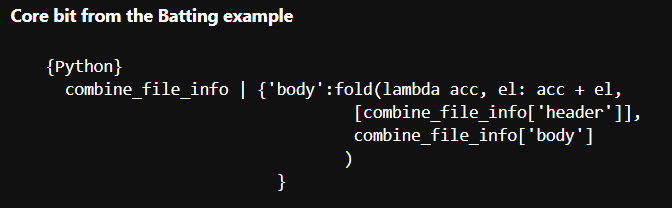

In [149]:
(files_by_type_w_combined_body :=
{type_: (record | {'body':fold(lambda acc, el: acc + el,
                           [record['header']],
                            record['body']
                          )
                  } 
        )
 for type_, record in zipped_files_w_header_folder.items()
}
) >> rec.map(rec.apply(body = tup.head(3))) #>> rec.subset(list(all_types)[:5])

{'Attendance': {'folder': './attendance_example_fixed_width/dsci494s7/',
  'type': 'Attendance',
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': ['Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
   'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n']},
 'Practice': {'folder': './attendance_example_fixed_width/dsci494s7/',
  'type': 'Practice',
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': ['Class,Section,Type,Module,ID,UserName,FirstN

## Create each of the output paths.

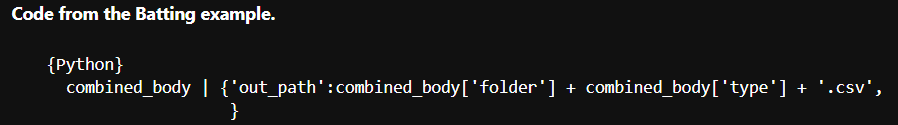

In [170]:
(with_out_path :=  # use the generic folder name, not the specific class folder
 {type_:record | {'out_path': './attendance_example_fixed_width/' + '_Part2_' + record['type'] + '.csv',}
                         
  for type_, record in files_by_type_w_combined_body.items()
 }
) >> rec.subset(all_types[:3]) >> rec.map(rec.apply(body = tup.head(3)))

{'Attendance': {'folder': './attendance_example_fixed_width/dsci494s7/',
  'type': 'Attendance',
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
  'body': ['Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_Time,Percent\n',
   'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,1,1,1,2019-01-14,14:00:00,2019-01-14,14:06:00,100%\n',
   'dsci494,s7,Attendance,,14460432,au9747cp,Jericho,Greer,2,1,1,2019-01-16,14:00:00,2019-01-16,14:08:00,100%\n'],
  'out_path': './attendance_example_fixed_width/_Part2_Attendance.csv'},
 'Practice': {'folder': './attendance_example_fixed_width/dsci494s7/',
  'type': 'Practice',
  'header': 'Class,Section,Type,Module,ID,UserName,FirstName,LastName,Attempt,Score,Out_Of,Attempt_Start_Date,Attempt_Start_Time,Attempt_End_Date,Attempt_End_T

## Writing out each of the files.

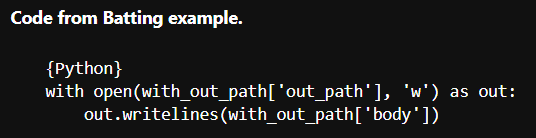

In [167]:
for type_, record in with_out_path.items():
    with open(record['out_path'], mode = 'w') as out:
        out.writelines(record['body'])
        print(f'Print all lines for {type_}\n')

Print all lines for Attendance

Print all lines for Practice



# Deliverables.  
Submit the following

1. A word document documenting your code/solution,
2. A notebook containing your work.  This should be a new/different notebook, separate from your solution to part 1.  This documents should assume that the unzipped file and all the composable modules are in the root directory (see below).